In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

In [2]:
# Prevent offset values in axis text
plt.rcParams['axes.formatter.useoffset'] = False

# The data

First let's load the data.

In [3]:
solutes = pd.read_excel('results.xlsx', sheet_name='solutes', index_col='id')
solutes.tail()

,description
id,
1,"Sugar, no drying"
2,"Sugar, 24 hours drying"
3,"Instant coffee, no drying"
4,"Instant coffee, 24 hours drying"


In [4]:
solutions = pd.read_excel('results.xlsx', sheet_name='solutions', index_col='id')
solutions.tail()

,solute_id,target_solute_weight,target_solution_weight,solute_weight,solution_weight,notes
id,,,,,,
20,4,2,100,1.999,100.04,NaN
21,2,10,100,10.000,99.96,Repeating solution 6
22,3,10,100,9.978,99.98,Repeating solution 11 (aluminum weighing boat)
23,3,8,100,7.962,100.01,"Repeating solution 12 (next day, aluminum weig..."
24,3,10,100,9.996,100.00,"Repeating solution 11 (next day, aluminum weig..."


In [5]:
trials = pd.read_excel('results.xlsx', sheet_name='trials', index_col='id')
trials.tail()

,solution_id,difluid_sample_tds_1,difluid_sample_temp_1,difluid_sample_n_1,difluid_sample_tds_2,difluid_sample_temp_2,difluid_sample_n_2,notes
id,,,,,,,,
72,23,7.65,17.3,1.34657,7.57,17.4,1.34644,NaN
73,23,7.63,17.3,1.34656,7.59,17.2,1.34647,NaN
74,24,9.68,18.5,1.35022,9.55,18.6,1.34997,NaN
75,24,9.65,17.9,1.35018,9.58,17.7,1.35004,NaN
76,24,9.68,17.5,1.35022,9.61,17.7,1.35008,NaN


Let's drop solutions 6, 11, 12, and 22, which are repeated later to address issues in the method used the first time.

In [6]:
trials.drop(trials[trials.solution_id.isin([6, 11, 12, 22])].index, inplace=True)
trials.tail()

,solution_id,difluid_sample_tds_1,difluid_sample_temp_1,difluid_sample_n_1,difluid_sample_tds_2,difluid_sample_temp_2,difluid_sample_n_2,notes
id,,,,,,,,
72,23,7.65,17.3,1.34657,7.57,17.4,1.34644,NaN
73,23,7.63,17.3,1.34656,7.59,17.2,1.34647,NaN
74,24,9.68,18.5,1.35022,9.55,18.6,1.34997,NaN
75,24,9.65,17.9,1.35018,9.58,17.7,1.35004,NaN
76,24,9.68,17.5,1.35022,9.61,17.7,1.35008,NaN


# Measured TDS vs. prepared TDS

For each solution we can calculate prepared tds.

In [7]:
solutions['prepared_tds'] = solutions.solute_weight / solutions.solution_weight * 100
solutions.tail()

,solute_id,target_solute_weight,target_solution_weight,solute_weight,solution_weight,notes,prepared_tds
id,,,,,,,
20,4,2,100,1.999,100.04,NaN,1.998201
21,2,10,100,10.000,99.96,Repeating solution 6,10.004002
22,3,10,100,9.978,99.98,Repeating solution 11 (aluminum weighing boat),9.979996
23,3,8,100,7.962,100.01,"Repeating solution 12 (next day, aluminum weig...",7.961204
24,3,10,100,9.996,100.00,"Repeating solution 11 (next day, aluminum weig...",9.996000


Let's try comparing this with the measured values.

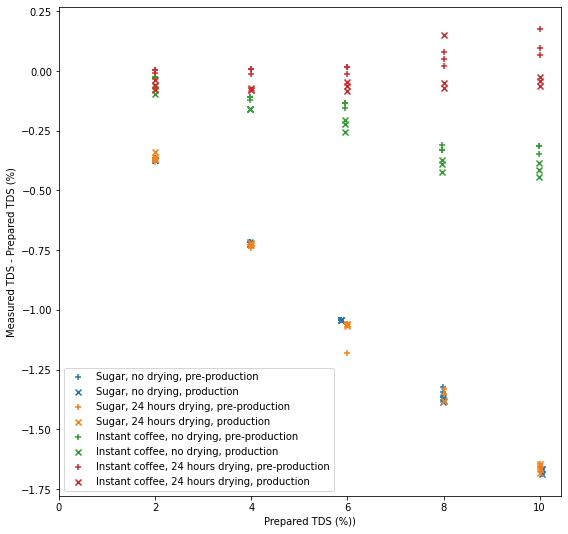

In [8]:
def PlotSolution(ax, df, prepared_tds, color, label):
    label1 = label + ', pre-production' if label else None
    label2 = label + ', production' if label else None
    
    ax.scatter([prepared_tds] * len(df), df.difluid_sample_tds_1 - prepared_tds, marker='+', color=color, label=label1)
    ax.scatter([prepared_tds] * len(df), df.difluid_sample_tds_2 - prepared_tds, marker='x', color=color, label=label2)

# Get default colours
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

# Create the figure
fig, ax = plt.subplots(figsize=(9,9))
fig.patch.set_facecolor('white')

# Plot the results
for j in solutes.index:
    matching_solutions = solutions[solutions.solute_id == j]
    label = solutes.loc[j].description
    
    for i in matching_solutions.index:
        matching_trials = trials[trials.solution_id == i]
        PlotSolution(ax, matching_trials, solutions.loc[i].prepared_tds, colors[j-1], label)
        label = None

# Set axis labels
ax.set_xlabel('Prepared TDS (%))')
ax.set_ylabel('Measured TDS - Prepared TDS (%)')

# Set axis ranges
ax.set_xlim((0, ax.get_xlim()[1]))

# Draw legend
ax.legend()

# Instant coffee solutions

Let's start by looking just at the coffee measurements.

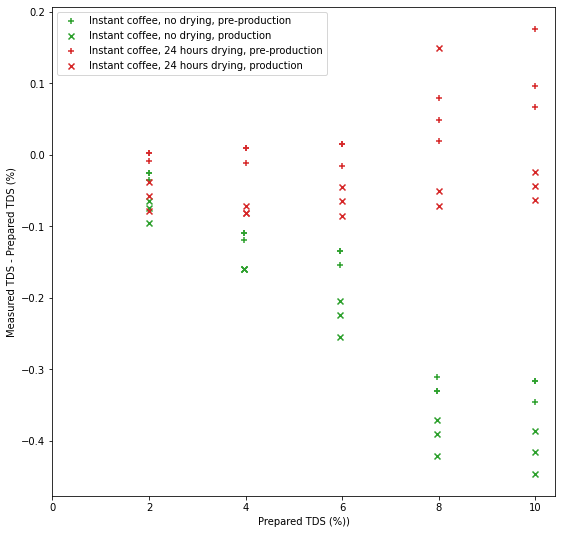

In [9]:
def PlotSolution(ax, df, prepared_tds, color, label):
    label1 = label + ', pre-production' if label else None
    label2 = label + ', production' if label else None
    
    ax.scatter([prepared_tds] * len(df), df.difluid_sample_tds_1 - prepared_tds, marker='+', color=color, label=label1)
    ax.scatter([prepared_tds] * len(df), df.difluid_sample_tds_2 - prepared_tds, marker='x', color=color, label=label2)

# Get default colours
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

# Create the figure
fig, ax = plt.subplots(figsize=(9,9))
fig.patch.set_facecolor('white')

# Plot the results
for j in [3,4]:
    matching_solutions = solutions[solutions.solute_id == j]
    label = solutes.loc[j].description
    
    for i in matching_solutions.index:
        matching_trials = trials[trials.solution_id == i]
        PlotSolution(ax, matching_trials, solutions.loc[i].prepared_tds, colors[j-1], label)
        label = None

# Set axis labels
ax.set_xlabel('Prepared TDS (%))')
ax.set_ylabel('Measured TDS - Prepared TDS (%)')

# Set axis ranges
ax.set_xlim((0, ax.get_xlim()[1]))

# Get axis ranges
xlim = ax.get_xlim()
ylim = ax.get_ylim()

# Draw legend
ax.legend()

There is a lot of spread in the high TDS samples. Most likely this is due to the timing sensitivity of these measurements. With repeated measurements of the same sample, TDS was observed to increase until, eventually, the refractometer gave an error. The most likely cause for this seems to be settling of suspended material, increasing scattering at the sample, blurring the line of total internal reflection, and eventually reducing contrast enough that the instrument can't determine a reading.

This suggests that the best measurement is the one with lowest TDS. Interestingly, for the samples without drying, we see a fairly clear linear edge at the lowest TDS.

What if we look at measured TDS vs. prepared TDS for the coffee samples?

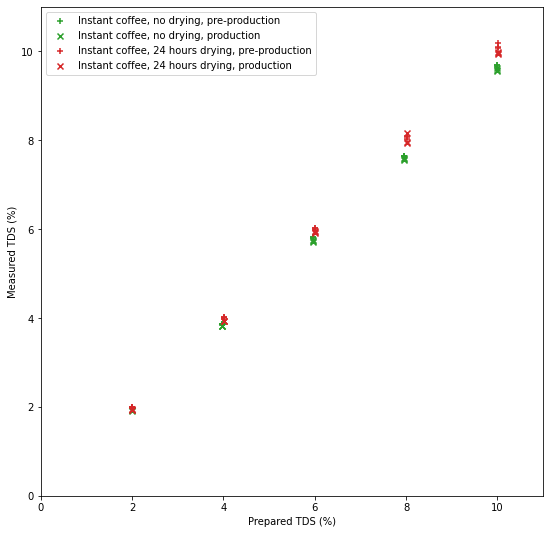

In [10]:
def PlotSolution(ax, df, prepared_tds, color, label):
    label1 = label + ', pre-production' if label else None
    label2 = label + ', production' if label else None
    
    ax.scatter([prepared_tds] * len(df), df.difluid_sample_tds_1, marker='+', color=color, label=label1)
    ax.scatter([prepared_tds] * len(df), df.difluid_sample_tds_2, marker='x', color=color, label=label2)

# Create the figure
fig, ax = plt.subplots(figsize=(9,9))
fig.patch.set_facecolor('white')

# Plot the results
for j in [3,4]:
    matching_solutions = solutions[solutions.solute_id == j]
    label = solutes.loc[j].description
    
    for i in matching_solutions.index:
        matching_trials = trials[trials.solution_id == i]
        PlotSolution(ax, matching_trials, solutions.loc[i].prepared_tds, colors[j-1], label)
        label = None

# Set axis labels
ax.set_xlabel('Prepared TDS (%)')
ax.set_ylabel('Measured TDS (%)')

# Set axis ranges
ax.set_xlim((0, 11))
ax.set_ylim((0, 11))

# Add legend
ax.legend()

Let's calculate a linear fit for the 4 combinations of refractometer and dried/undried solute, with a y-intercept of 0 (i.e., measured should be 0 when prepared TDS is 0).

In [11]:
# Exclude outliers from the fit
trials_fit = trials[~trials['solution_id'].isin([21,22,11,23])]

fitfunc = lambda x, b: b * x
fits = []

for j in [3,4]:
    sub_solutions = solutions[solutions.solute_id == j]
    
    xs = np.array([])
    ys_1 = np.array([])
    ys_2 = np.array([])

    for i in sub_solutions.index:
        matching_trials = trials_fit[trials_fit.solution_id == i]
        prepared_tds = sub_solutions.loc[i].prepared_tds
        
        xs = np.concatenate([xs, [prepared_tds] * len(matching_trials)])
        ys_1 = np.concatenate([ys_1, matching_trials.difluid_sample_tds_1.values])
        ys_2 = np.concatenate([ys_2, matching_trials.difluid_sample_tds_2.values])
        
    fits.append(curve_fit(fitfunc, xs, ys_1)[0])
    fits.append(curve_fit(fitfunc, xs, ys_2)[0])

fits

[array([0.97031664]),
 array([0.95935215]),
 array([1.00704567]),
 array([0.99459936])]

How do the slopes of the dried samples compare with the undried samples?

In [12]:
print(fits[3][0] / fits[1][0])
print(fits[2][0] / fits[0][0])

1.036740635456405
1.037852623570661


How about the old refractometer vs. the new refractometer?

In [13]:
print(fits[2][0] / fits[3][0])
print(fits[0][0] / fits[1][0])

1.01251388800882
1.0114290486169695


Now we plot.

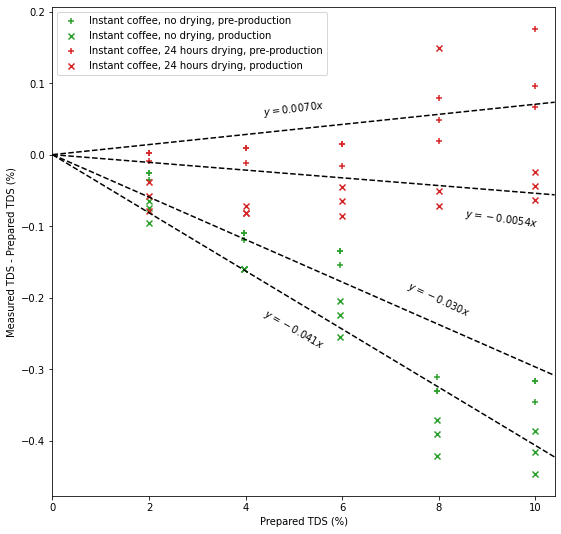

In [14]:
def PlotSolution(ax, df, prepared_tds, color, label):
    label1 = label + ', pre-production' if label else None
    label2 = label + ', production' if label else None
    
    ax.scatter([prepared_tds] * len(df), df.difluid_sample_tds_1 - prepared_tds, marker='+', color=color, label=label1)
    ax.scatter([prepared_tds] * len(df), df.difluid_sample_tds_2 - prepared_tds, marker='x', color=color, label=label2)

# Create the figure
fig, ax = plt.subplots(figsize=(9,9))
fig.patch.set_facecolor('white')

# Plot the fits
for b in fits:
    xs = np.linspace(xlim[0], xlim[1], 200)
    ys = fitfunc(xs, b)
    
    ax.plot(xs, ys - xs, c='k', ls='--')
    
ax.text(5.0, -0.270, f'$y = {fits[1][0]-1:.3f} x$', rotation=-30, horizontalalignment='center')
ax.text(8.0, -0.225, f'$y = {fits[0][0]-1:.3f} x$', rotation=-25, horizontalalignment='center')
ax.text(9.3, -0.1, f'$y = {fits[3][0]-1:.4f} x$', rotation=-8, horizontalalignment='center')
ax.text(5.0, 0.055, f'$y = {fits[2][0]-1:.4f} x$', rotation=7, horizontalalignment='center')

# Plot the results
for j in [3,4]:
    matching_solutions = solutions[solutions.solute_id == j]
    label = solutes.loc[j].description
    
    for i in matching_solutions.index:
        matching_trials = trials[trials.solution_id == i]
        PlotSolution(ax, matching_trials, solutions.loc[i].prepared_tds, colors[j-1], label)
        label = None

# Set axis labels
ax.set_xlabel('Prepared TDS (%)')
ax.set_ylabel('Measured TDS - Prepared TDS (%)')

# Set axis ranges
ax.set_xlim(xlim)
ax.set_ylim(ylim)

# Add legend
ax.legend()

# Sucrose solutions

Now let's look just at the sugar measurements and compare with the reference curves.

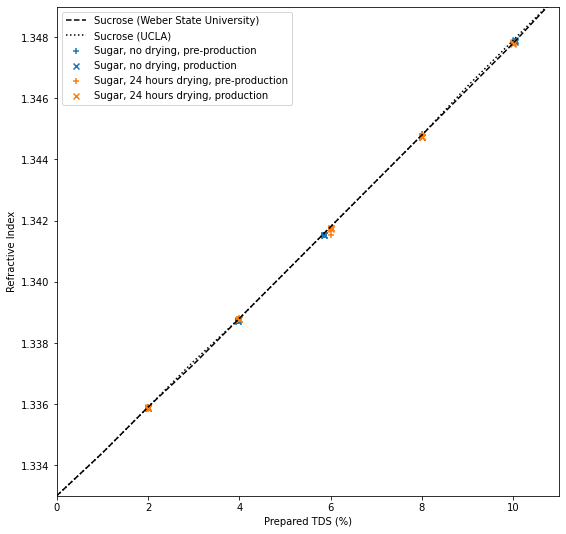

In [15]:
def PlotSheet(sheet, label, ls, c):
    df = pd.read_excel('../refractive-index/refractive-index.xlsx', sheet_name=sheet)
    ax.plot(df.tds, df.n, label=label, c=c, ls=ls)

def PlotSolution(ax, df, prepared_tds, color, label):
    label1 = label + ', pre-production' if label else None
    label2 = label + ', production' if label else None
    
    ax.scatter([prepared_tds] * len(df), df.difluid_sample_n_1, marker='+', color=color, label=label1)
    ax.scatter([prepared_tds] * len(df), df.difluid_sample_n_2, marker='x', color=color, label=label2)

# Create the figure
fig, ax = plt.subplots(figsize=(9,9))
fig.patch.set_facecolor('white')

# Sheets used in plot
sheets_labels = [('sucrose_3', 'Sucrose (Weber State University)', 'dashed', 'k'),
                 ('sucrose_2', 'Sucrose (UCLA)', 'dotted', 'k')]

# Plot reference data
for sheet, label, ls, c in sheets_labels:
    PlotSheet(sheet, label, ls, c)

# Plot the results
for j in [1,2]:
    matching_solutions = solutions[solutions.solute_id == j]
    label = solutes.loc[j].description
    
    for i in matching_solutions.index:
        matching_trials = trials[trials.solution_id == i]
        PlotSolution(ax, matching_trials, solutions.loc[i].prepared_tds, colors[j-1], label)
        label = None

# Set axis labels
ax.set_xlabel('Prepared TDS (%)')
ax.set_ylabel('Refractive Index')

# Set axis ranges
ax.set_xlim((0, 11))
ax.set_ylim((1.333, 1.349))

# Add legend
ax.legend()

Let's do detail plots for each set of points.

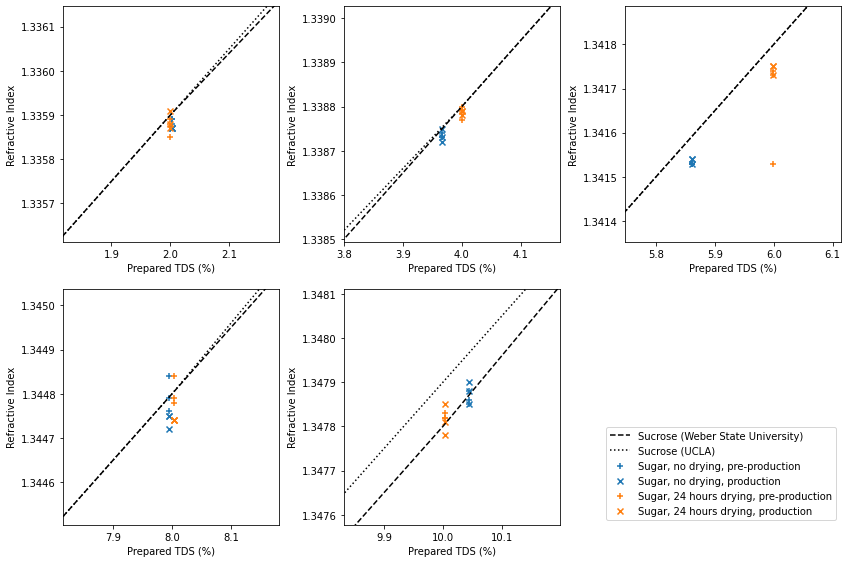

In [16]:
def PlotSheet(ax, sheet, label, ls, c):
    df = pd.read_excel('../refractive-index/refractive-index.xlsx', sheet_name=sheet)
    ax.plot(df.tds, df.n, label=label, c=c, ls=ls)

def PlotSolution(ax, df, prepared_tds, color, label):
    label1 = label + ', pre-production' if label else None
    label2 = label + ', production' if label else None
    
    ax.scatter([prepared_tds] * len(df), df.difluid_sample_n_1, marker='+', color=color, label=label1)
    ax.scatter([prepared_tds] * len(df), df.difluid_sample_n_2, marker='x', color=color, label=label2)

def PlotGroup(ax, solution_ids, mag):
    # Sheets used in plot
    sheets_labels = [('sucrose_3', 'Sucrose (Weber State University)', 'dashed', 'k'),
                     ('sucrose_2', 'Sucrose (UCLA)', 'dotted', 'k')]

    # Plot reference data
    for sheet, label, ls, c in sheets_labels:
        PlotSheet(ax, sheet, label, ls, c)

    # Get matching solutions
    matching_solutions = solutions[solutions.index.isin(solution_ids)]
    
    # Plot the results
    for j in [1,2]:
        label = solutes.loc[j].description
        sub_solutions = matching_solutions[matching_solutions.solute_id == j]

        for i in sub_solutions.index:
            matching_trials = trials[trials.solution_id == i]
            PlotSolution(ax, matching_trials, sub_solutions.loc[i].prepared_tds, colors[j-1], label)
            label = None

    # Set axis labels
    ax.set_xlabel('Prepared TDS (%)')
    ax.set_ylabel('Refractive Index')

    # Get center
    xavg = matching_solutions.prepared_tds.mean()
    y1 = trials[trials.solution_id.isin(solution_ids)].difluid_sample_n_1.values
    y2 = trials[trials.solution_id.isin(solution_ids)].difluid_sample_n_2.values
    yavg = np.concatenate([y1, y2]).mean()
    
    # Get range
    xrange = (11 - 0) / mag
    yrange = (1.349 - 1.333) / mag
    
    # Set axis ranges
    ax.set_xlim((xavg - xrange / 2, xavg + xrange / 2))
    ax.set_ylim((yavg - yrange / 2, yavg + yrange / 2))

# Create the figure
fig, axs = plt.subplots(2, 3, figsize=(13.5, 9))
fig.patch.set_facecolor('white')

# Plot details
PlotGroup(axs[0][0], solutions[(solutions.solute_id.isin([1,2])) & (solutions.target_solute_weight == 2)].index, 30)
PlotGroup(axs[0][1], solutions[(solutions.solute_id.isin([1,2])) & (solutions.target_solute_weight == 4)].index, 30)
PlotGroup(axs[0][2], solutions[(solutions.solute_id.isin([1,2])) & (solutions.target_solute_weight == 6)].index, 30)
PlotGroup(axs[1][0], solutions[(solutions.solute_id.isin([1,2])) & (solutions.target_solute_weight == 8)].index, 30)
PlotGroup(axs[1][1], solutions[(solutions.solute_id.isin([1,2])) & (solutions.target_solute_weight == 10)].index, 30)
axs[1][2].axis('off')

# Add legend
h, l = axs[0][0].get_legend_handles_labels()
fig.legend(h, l, bbox_to_anchor=(0.9, 0.1), loc = 'lower right')

# Set the spacing between subplots
plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=0.9,
                    top=0.9,
                    wspace=0.3,
                    hspace=0.2)

Other than the two outliers, these are all very close to the dashed reference curve. The two units look very similar, and there is no clear difference between dried and undried solutes.

# TDS vs. refractive index

We can also look at the relationship between refractive index and TDS for all measurements.

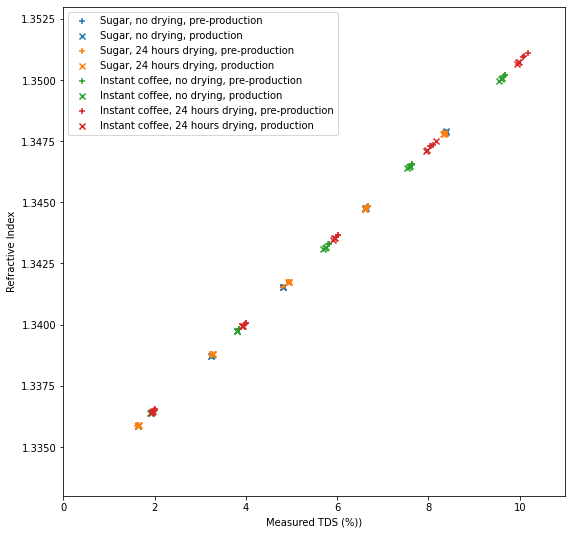

In [17]:
def PlotSolution(ax, df, color, label):
    label1 = label + ', pre-production' if label else None
    label2 = label + ', production' if label else None
    
    ax.scatter(df.difluid_sample_tds_1, df.difluid_sample_n_1, marker='+', color=color, label=label1)
    ax.scatter(df.difluid_sample_tds_2, df.difluid_sample_n_2, marker='x', color=color, label=label2)

# Create the figure
fig, ax = plt.subplots(figsize=(9,9))
fig.patch.set_facecolor('white')

# Plot the results
for j in solutes.index:
    matching_solutions = solutions[solutions.solute_id == j]
    label = solutes.loc[j].description
    
    for i in matching_solutions.index:
        matching_trials = trials[trials.solution_id == i]
        PlotSolution(ax, matching_trials, colors[j-1], label)
        label = None

# Set axis labels
ax.set_xlabel('Measured TDS (%))')
ax.set_ylabel('Refractive Index')

# Set axis ranges
ax.set_xlim((0, 11))
ax.set_ylim((1.333, 1.353))

# Draw legend
ax.legend()

Let's do a quadratic fit then subtract that in the plot.

In [18]:
fitfunc = lambda x, a, b, c: a * x**2 + b * x + c

xs = np.concatenate([trials.difluid_sample_tds_1.values, trials.difluid_sample_tds_2.values])
ys = np.concatenate([trials.difluid_sample_n_1.values, trials.difluid_sample_n_2.values])
        
fit = curve_fit(fitfunc, xs, ys)[0]
fit

array([1.48137345e-06, 1.76525141e-03, 1.33298872e+00])

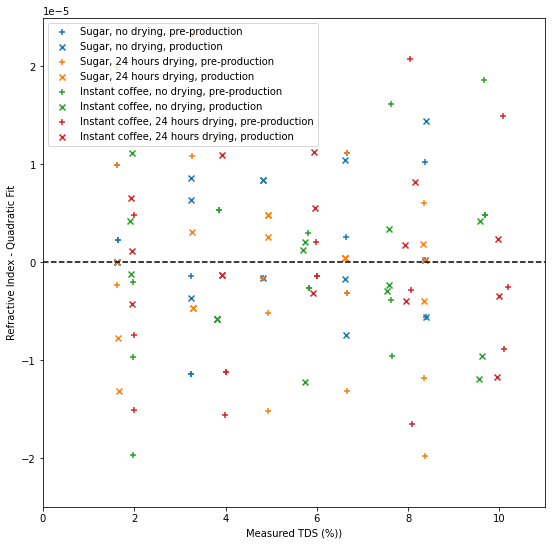

In [19]:
def PlotSolution(ax, df, color, label):
    label1 = label + ', pre-production' if label else None
    label2 = label + ', production' if label else None
    
    fit_ys = fitfunc(df.difluid_sample_tds_1, fit[0], fit[1], fit[2])
    ax.scatter(df.difluid_sample_tds_1, df.difluid_sample_n_1 - fit_ys, marker='+', color=color, label=label1)

    fit_ys = fitfunc(df.difluid_sample_tds_2, fit[0], fit[1], fit[2])
    ax.scatter(df.difluid_sample_tds_2, df.difluid_sample_n_2 - fit_ys, marker='x', color=color, label=label2)

# Create the figure
fig, ax = plt.subplots(figsize=(9,9))
fig.patch.set_facecolor('white')

# Plot the fit
xs = np.linspace(0, 11, 200)
ys = fitfunc(xs, fit[0], fit[1], fit[2])
ax.plot(xs, ys - ys, c='k', ls='--')

# Plot the results
for j in solutes.index:
    matching_solutions = solutions[solutions.solute_id == j]
    label = solutes.loc[j].description
    
    for i in matching_solutions.index:
        matching_trials = trials[trials.solution_id == i]
        PlotSolution(ax, matching_trials, colors[j-1], label)
        label = None

# Set axis labels
ax.set_xlabel('Measured TDS (%))')
ax.set_ylabel('Refractive Index - Quadratic Fit')

# Set axis ranges
ax.set_xlim((0, 11))
ax.set_ylim((-2.5e-5, 2.5e-5))

# Draw legend
ax.legend(loc='upper left')

The actual fit certainly includes temperature as well, but even ignoring temperature, our quadratic fit is within about ±0.00002 in refractive index for all samples. This suggests that the two refractometers are using the same conversion from refractive index to TDS.